# Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix,accuracy_score
import tensorflow as tf
import torch
import torchvision
from torch.utils.data import Dataset
from PIL import Image
import os
import csv

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import time
import copy
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# CSV DataLoader #

In [ ]:
class CSVDataLoader:
    def __init__(self, file_path, split, transform = None):
        self.split = split
        self.df = pd.read_csv(file_path)
        self.transform = transform

    # Returns image, label
    def __getitem__(self, index):
        image_id = self.df.loc[index, "ImageID"]
        label = 1 if self.df.loc[index, "abnormal"] else 0
        if label:
          image_dir = "abnormal"
        else:
          image_dir = "normal"

        image = Image.open(f'data{image_id}')

        # Convert grayscale image to RGB
        image = image.convert("RGB")

        if self.transform:
          image = self.transform(image)

        return image, label

    def __len__(self):
        return self.df.shape[0]

In [ ]:
# These transforms that we'll execute in sequence
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ]),

     'val': transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ]),

     'test': transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])
}


In [ ]:
dsets = {}
dsets["train"] = CSVDataLoader( 'experiment2_train.csv', "train", data_transforms['train'])
dsets["val"] = CSVDataLoader( 'experiment2_val.csv', "val", data_transforms['val'])
dsets["test"] = CSVDataLoader( 'china_selected_test.csv', "test", data_transforms['test']) # save this data to the mac

In [ ]:
# Globals
BATCH_SIZE = 32

In [ ]:
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val', 'test']}

In [ ]:
dset_loaders = {}
dset_loaders["train"] = torch.utils.data.DataLoader(dsets["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["val"] = torch.utils.data.DataLoader(dsets["val"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["test"] = torch.utils.data.DataLoader(dsets["test"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

# Model Settings

In [ ]:
# TRAINING SETTINGS
NUM_EPOCHS = 7 # This is 10 for Experiments 1, 2, and 3

# LEARNING RATE SETTINGS
BASE_LR = 0.0001 # This is 0.001 for Experiments 1, 2, and 3
DECAY_WEIGHT = 0.1 # factor by which the learning rate is reduced.
EPOCH_DECAY = 30 # number of epochs after which the learning rate is decayed exponentially by DECAY_WEIGHT.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset


# DATALOADER PROPERTIES
BATCH_SIZE = 32 # originally 10


# GPU SETTINGS
CUDA_DEVICE = 0 # Enter device ID of your gpu if you want to run on gpu. Otherwise neglect.
# Set to 1 to use GPU if on google colab
GPU_MODE = 1 # set to 1 if want to run on gpu.


# SETTINGS FOR DISPLAYING ON TENSORBOARD
USE_TENSORBOARD = 0 #if you want to use tensorboard set this to 1.
TENSORBOARD_SERVER = "YOUR TENSORBOARD SERVER ADDRESS HERE" # If you set.
EXP_NAME = "fine_tuning_experiment" # if using tensorboard, enter name of experiment you want it to be displayed as.

In [ ]:
## If you want to use the GPU, set GPU_MODE TO 1 in config file
use_gpu = GPU_MODE
if use_gpu:
    torch.cuda.set_device(CUDA_DEVICE)

# The Model

In [ ]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=100):
    since = time.time()

    best_model = model
    best_acc = 0.0

    accuracies = {'train': [], 'val': []}
    losses = {'train': [], 'val': []}
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to eval mode for validation (no need to track gradients)

            running_loss = 0.0
            running_corrects = 0

            counter=0

            # Initialize variables to store false positives and false negatives
            false_positives = 0
            false_negatives = 0
            true_positives = 0

            # Iterate over data, getting one batch of inputs (images) and labels each time.
            for data in dset_loaders[phase]:
                inputs, labels = data

                if use_gpu:
                    try:
                        inputs, labels = Variable(inputs.float().cuda()), Variable(labels.long().cuda())
                    except Exception as e:
                        print("ERROR! here are the inputs and labels before we print the full stack trace:")
                        print(inputs, labels)
                        raise e
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # Set gradient to zero to delete history of computations in previous epoch. Track operations so that differentiation can be done automatically.
                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)

                # Print a line every 10 batches so you have something to watch and don't feel like the program isn't running.
                if counter%10==0:
                    print("Reached batch iteration", counter)

                counter+=1

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                try:
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
                except:
                    print('unexpected error, could not calculate loss or do a sum.')

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / float(dset_sizes[phase])
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)

            # deep copy the model
            if phase == 'val':
                if USE_TENSORBOARD:
                    foo.add_scalar_value('epoch_loss', epoch_loss,step=epoch)
                    foo.add_scalar_value('epoch_acc', epoch_acc,step=epoch)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model = copy.deepcopy(model)
                    print('new best accuracy =', best_acc)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('returning and looping back')

    return best_model, accuracies, losses


# This function changes the learning rate as the model trains.
# If the learning rate is too high, training tends to be unstable and it's harder to converge on an optimal set of weights.
# But, if learning rate is too low, learning is too slow and you won't converge in a reasonable time frame. A good compromise
# is to start out with a high learning rate and then reduce it over time.
def exp_lr_scheduler(optimizer, epoch, init_lr=BASE_LR, lr_decay_epoch=EPOCH_DECAY):
    """Decay learning rate by a factor of DECAY_WEIGHT every lr_decay_epoch epochs."""
    lr = init_lr * (DECAY_WEIGHT**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

# Model Architecture and Training

In [ ]:
### SECTION 4 - DEFINING MODEL ARCHITECTURE.

##################
# We use Resnet18 here. If you have more computational power, feel free to swap it with Resnet50, Resnet100 or Resnet152.
# For fine tuning or transfer learning, we will use the pretrained net weights.
##################
model_ft = models.resnet18(pretrained = True)
# Freeze all the parameters in the convolutional layers
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)


criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    model_ft.cuda()

optimizer_ft = optim.RMSprop(model_ft.parameters(), lr=0.0001)


# Run the functions and save the best model in the function model_ft.
model_ft, accuracies, losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

# Save model
torch.save(model_ft.state_dict(), 'fine_tuned_best_model.pt')


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------
Epoch 0/6
----------
LR is set to 0.0001
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch iteration 110
Reached batch iteration 120
Reached batch iteration 130
Reached batch iteration 140
Reached batch iteration 150
Reached batch iteration 160
train Loss: 0.0210 Acc: 0.5950
Reached batch iteration 0
Reached batch iteration 10
val Loss: 0.0199 Acc: 0.6550
new best accuracy = 0.655
----------
Epoch 1/6
----------
Reached batch iteration 0
Reached batch iteration 10
Reached batch iteration 20
Reached batch iteration 30
Reached batch iteration 40
Reached batch iteration 50
Reached batch iteration 60
Reached batch iteration 70
Reached batch iteration 80
Reached batch iteration 90
Reached batch iteration 100
Reached batch i

# Results after Model is Trained

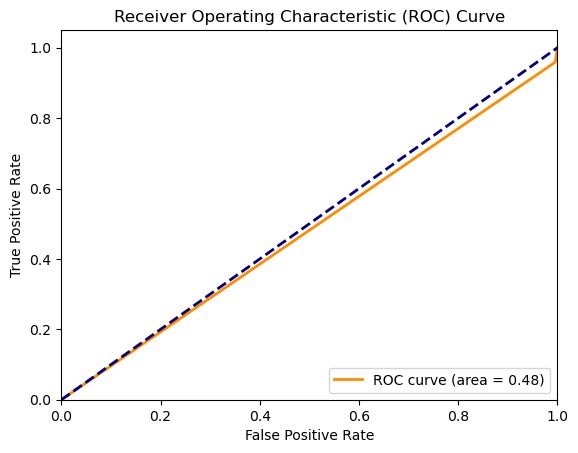

Accuracy: 0.6009615384615384
Precision: 0.6161449752883031
Recall: 0.958974358974359
F1 Score: 0.7502507522567703
False Positives: 233
False Negatives: 16
Sensitivity: 0.958974358974359
Specificity: 0.004273504273504274
AUC 0.48162393162393163


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate confusion matrix to compute false positives, false negatives, and sensitivity
    conf_matrix = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = conf_matrix.ravel()

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # Calculate ROC curve and AUC for test data
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    # Save the plot as an image
    # plt.savefig('ROC_plots/roc_curve_experiment4(1).png')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("False Positives:", FP)
    print("False Negatives:", FN)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("AUC", roc_auc)

    return accuracy, precision, recall, f1

# Example usage:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model_ft, criterion, dset_loaders['test'])


# Reload the weights for fine-tuning (Experiments 4 and 5 only)

In [ ]:
def load_weights(model, path):
    model.load_state_dict(torch.load(path))

# Instantiate ResNet18 model without pretrained weights
fine_tuned_model_ft = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes in the checkpoint
num_ftrs = fine_tuned_model_ft.fc.in_features

# Assuming you have 2 output classes
fine_tuned_model_ft.fc = nn.Linear(num_ftrs, 2)


load_weights(fine_tuned_model_ft, 'fine_tuned_best_model.pt')

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Fine-tuned train and validaiton
dsets = {}
dsets["train"] = CSVDataLoader( 'experiment1_train.csv', "train", data_transforms['train'])
dsets["val"] = CSVDataLoader( 'experiment1_val.csv', "val", data_transforms['val'])
dsets["test"] = CSVDataLoader( 'china_selected_test.csv', "test", data_transforms['test'])

In [ ]:
dset_sizes = {split: len(dsets[split]) for split in ['train', 'val', 'test']}

In [ ]:
dset_loaders = {}
dset_loaders["train"] = torch.utils.data.DataLoader(dsets["train"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["val"] = torch.utils.data.DataLoader(dsets["val"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)
dset_loaders["test"] = torch.utils.data.DataLoader(dsets["test"], batch_size=BATCH_SIZE, shuffle=True, num_workers = 0)

In [ ]:
torch.backends.cudnn.enabled = False

In [ ]:
# Change model parameters for fine-tuning
NUM_EPOCHS=5
BASE_LR = 0.001

# Fine-tune the model

In [ ]:
criterion = nn.CrossEntropyLoss()

if use_gpu:
    criterion.cuda()
    fine_tuned_model_ft.cuda()

optimizer_ft = optim.RMSprop(fine_tuned_model_ft.parameters(), lr=0.0001)


# Run the functions and save the best model in the function model_ft.
fine_tuned_model_ft, accuracies, losses = train_model(fine_tuned_model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=NUM_EPOCHS)

for split in ['train', 'val']:
    print(split, "accuracies by epoch:", accuracies[split])
    print(split, "losses by epoch:", losses[split])

# Save model
torch.save(fine_tuned_model_ft.state_dict(), 'fine_tuned_best_model.pt')

----------
Epoch 0/4
----------
LR is set to 0.0001
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0086 Acc: 0.8778
Reached batch iteration 0
val Loss: 0.0068 Acc: 0.8800
new best accuracy = 0.88
----------
Epoch 1/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0016 Acc: 0.9889
Reached batch iteration 0
val Loss: 0.0114 Acc: 0.8600
----------
Epoch 2/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0015 Acc: 0.9889
Reached batch iteration 0
val Loss: 0.0092 Acc: 0.9200
new best accuracy = 0.92
----------
Epoch 3/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0003 Acc: 0.9978
Reached batch iteration 0
val Loss: 0.0051 Acc: 0.9400
new best accuracy = 0.94
----------
Epoch 4/4
----------
Reached batch iteration 0
Reached batch iteration 10
train Loss: 0.0038 Acc: 0.9844
Reached batch iteration 0
val Loss: 0.0142 Acc: 0.8200
Training complete in 0m 52s
Best val Acc: 0.940000

# Results after the model is fine-tuned

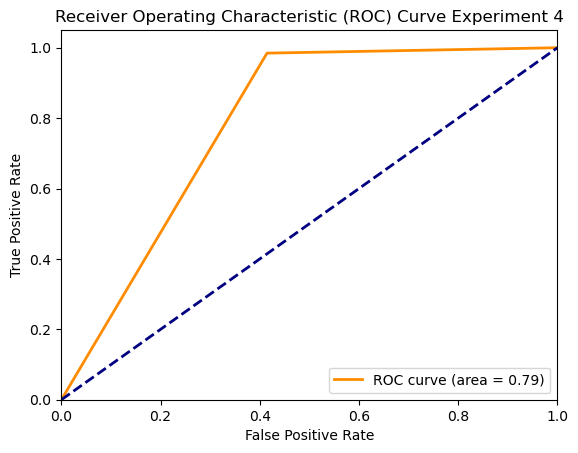

Accuracy: 0.8349358974358975
Precision: 0.7983367983367984
Recall: 0.9846153846153847
F1 Score: 0.8817451205510907
False Positives: 97
False Negatives: 6
Sensitivity: 0.9846153846153847
Specificity: 0.5854700854700855
AUC 0.7850427350427349


In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, criterion, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Calculate confusion matrix to compute false positives, false negatives, and sensitivity
    conf_matrix = confusion_matrix(all_labels, all_preds)
    TN, FP, FN, TP = conf_matrix.ravel()

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    # Calculate ROC curve and AUC for test data
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Experiment 4')
    plt.legend(loc="lower right")
    # Save the plot as an image
    # plt.savefig('ROC_plots/roc_curve_experiment5.png')
    plt.show()

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("False Positives:", FP)
    print("False Negatives:", FN)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("AUC", roc_auc)

    return accuracy, precision, recall, f1

# Example usage:
test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(fine_tuned_model_ft, criterion, dset_loaders['test'])
